## Back Test Results Binary Classification

In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(1631, 11)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,1209.0,46.0,Bullish,53.0,SELL,41.0,SELL,36.0,BUY,79.0,SELL
1,4855.0,34.0,Bearish,76.0,SELL,0.0,BUY,75.0,BUY,55.0,SELL
2,4455.0,41.0,Bullish,0.0,BUY,85.0,SELL,10.0,SELL,19.0,BUY
3,3622.0,60.0,Bullish,59.0,BUY,48.0,SELL,78.0,SELL,45.0,BUY
4,7044.0,87.0,Bullish,8.0,BUY,65.0,SELL,97.0,BUY,71.0,SELL


## Drop Predictions with Less than 20% LR Fit

In [4]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [5]:
dataset.shape

(1195, 11)

## One-Hot Encoding

In [6]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [7]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [8]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [9]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-53.0,-41.0,36.0,-79.0
1,0,-76.0,0.0,75.0,-55.0
2,1,0.0,-85.0,-10.0,19.0
3,1,59.0,-48.0,-78.0,45.0
4,1,8.0,-65.0,97.0,-71.0


In [10]:
data = dataset.sample(frac=0.80, random_state=750).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (956, 5)
Unseen Data For Predictions: (239, 5)


# Create Unseen DataFrame

In [11]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,0,-93.0,-48.0,-2.0,37.0
1,0,-22.0,-61.0,-4.0,-20.0
2,1,-1.0,-12.0,64.0,-3.0
3,0,31.0,-40.0,3.0,-38.0
4,1,63.0,7.0,74.0,-0.0


In [12]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(956, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5261,0.5193,0.5832,0.5397,0.5596,0.0477,0.0484,0.0400
qda,Quadratic Discriminant Analysis,0.5231,0.5197,0.6780,0.5329,0.5955,0.0338,0.0353,0.0050
lr,Logistic Regression,0.5097,0.4605,0.8252,0.5182,0.6357,-0.0066,-0.0055,0.2280
ridge,Ridge Classifier,0.5097,0.0000,0.8252,0.5182,0.6357,-0.0066,-0.0055,0.0040
lda,Linear Discriminant Analysis,0.5097,0.4605,0.8252,0.5182,0.6357,-0.0066,-0.0055,0.0040
svm,SVM - Linear Kernel,0.5081,0.0000,0.5545,0.5251,0.5376,0.0130,0.0130,0.0040
lightgbm,Light Gradient Boosting Machine,0.5068,0.4906,0.5430,0.5201,0.5287,0.0110,0.0121,0.0110
rf,Random Forest Classifier,0.5036,0.5038,0.5283,0.5224,0.5242,0.0048,0.0049,0.0480
gbc,Gradient Boosting Classifier,0.5007,0.4919,0.5543,0.5201,0.5356,-0.0039,-0.0042,0.0150
ada,Ada Boost Classifier,0.5006,0.4976,0.5803,0.5200,0.5477,-0.0053,-0.0060,0.0150


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

stop

In [14]:
MODEL = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5821,0.5665,0.6857,0.5854,0.6316,0.1557,0.1583
1,0.5821,0.6826,0.6857,0.5854,0.6316,0.1557,0.1583
2,0.4925,0.4478,0.5429,0.5135,0.5278,-0.0197,-0.0197
3,0.5075,0.5321,0.6286,0.5238,0.5714,0.0036,0.0037
4,0.5224,0.5335,0.5714,0.5405,0.5556,0.0403,0.0404
5,0.4776,0.4219,0.4571,0.5000,0.4776,-0.0427,-0.0429
6,0.5075,0.4397,0.5429,0.5278,0.5352,0.0116,0.0116
7,0.5821,0.5763,0.6000,0.6000,0.6000,0.1625,0.1625
8,0.5522,0.5477,0.6471,0.5500,0.5946,0.1019,0.1036
9,0.4545,0.4444,0.4706,0.4706,0.4706,-0.0919,-0.0919


In [15]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6716,0.6688,0.8000,0.6512,0.7179,0.3348,0.3451
1,0.5672,0.5830,0.7143,0.5682,0.6329,0.1220,0.1268
2,0.5224,0.4670,0.5714,0.5405,0.5556,0.0403,0.0404
3,0.5373,0.5768,0.6571,0.5476,0.5974,0.0640,0.0655
4,0.5522,0.5607,0.6571,0.5610,0.6053,0.0954,0.0970
5,0.5075,0.5411,0.4571,0.5333,0.4923,0.0195,0.0197
6,0.5075,0.4812,0.5143,0.5294,0.5217,0.0143,0.0143
7,0.5224,0.5036,0.5429,0.5429,0.5429,0.0429,0.0429
8,0.4478,0.5107,0.4706,0.4571,0.4638,-0.1052,-0.1053
9,0.4394,0.4228,0.5000,0.4595,0.4789,-0.1253,-0.1259


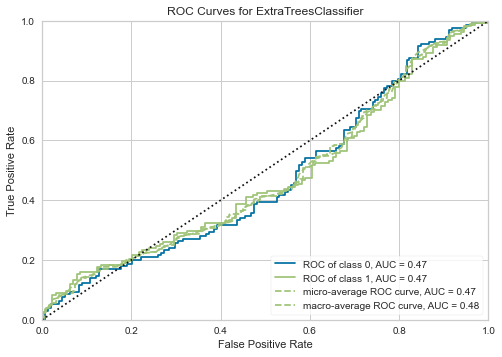

In [16]:
plot_model(TUNED_MODEL, plot = 'auc')

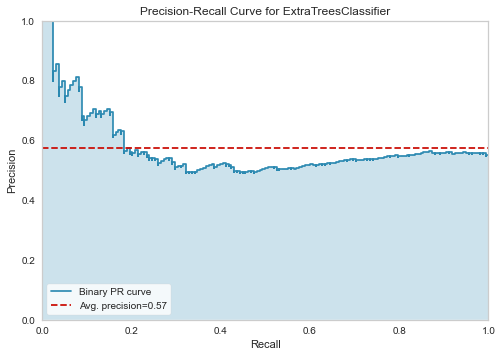

In [17]:
plot_model(TUNED_MODEL, plot = 'pr')

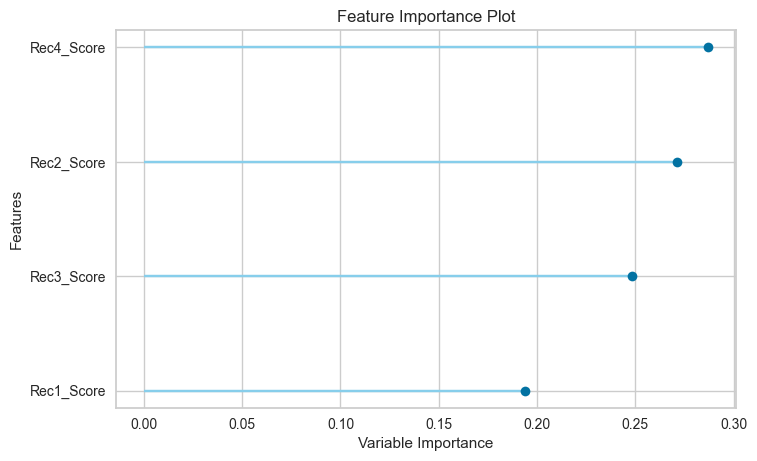

In [18]:
plot_model(TUNED_MODEL, plot='feature')

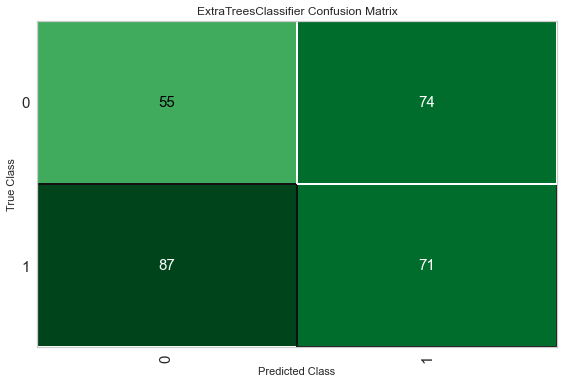

In [19]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [20]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.4390,0.4732,0.4494,0.4897,0.4686,-0.1231,-0.1236


In [21]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [22]:
print(FINAL_MODEL)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)


In [23]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7770,0.8675,0.8101,0.7901,0.8000,0.5481,0.5483


In [24]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,0,-93.0,-48.0,-2.0,37.0,0,0.5806
1,0,-22.0,-61.0,-4.0,-20.0,1,0.5416
2,1,-1.0,-12.0,64.0,-3.0,1,0.5584
3,0,31.0,-40.0,3.0,-38.0,1,0.5295
4,1,63.0,7.0,74.0,-0.0,0,0.5021


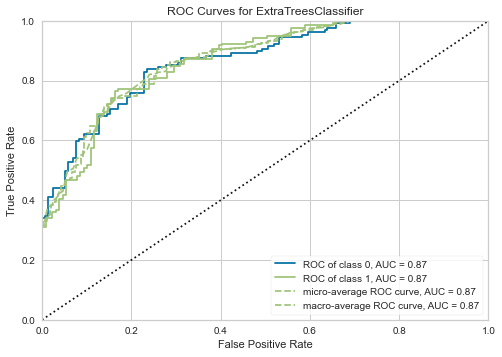

In [25]:
plot_model(FINAL_MODEL, plot = 'auc')

In [26]:
save_model(FINAL_MODEL,'FINAL_ET_25Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight='balanced_subsample',
                                       criterion='gini', max_depth=6,
                    

In [27]:
SAVED_FINAL_MODEL = load_model('FINAL_ET_25Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Loaded


In [28]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [29]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,0,-93.0,-48.0,-2.0,37.0,0,0.5806
1,0,-22.0,-61.0,-4.0,-20.0,1,0.5416
2,1,-1.0,-12.0,64.0,-3.0,1,0.5584
3,0,31.0,-40.0,3.0,-38.0,1,0.5295
4,1,63.0,7.0,74.0,-0.0,0,0.5021
5,0,81.0,1.0,67.0,54.0,0,0.5110
6,0,-7.0,39.0,88.0,34.0,0,0.5870
7,0,-70.0,47.0,-1.0,-46.0,0,0.5177
8,1,0.0,6.0,-33.0,-60.0,0,0.5044
9,1,81.0,10.0,-0.0,63.0,0,0.6124
